### Kaggle Tabular Playground Competition

This is a notebook showing my process for this [kaggle competition](https://www.kaggle.com/c/tabular-playground-series-dec-2021/overview). The aim of this notebook is to display my routine machine learning process start to finish. 

### Imports

In [60]:
#general imports
import os
import time
import pandas as pd
import numpy as np

#visualization imports
from matplotlib import pyplot as plt
import seaborn as sns

#machine learning imports
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
#read in data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,3189,40,8,30,13,3270,206,234,193,...,0,0,0,0,0,0,0,0,0,1
1,1,3026,182,5,280,29,3270,233,240,106,...,0,0,0,0,0,0,0,0,0,2
2,2,3106,13,7,351,37,2914,208,234,137,...,0,0,0,0,0,0,0,0,0,1
3,3,3022,276,13,192,16,3034,207,238,156,...,0,0,0,0,0,0,0,0,0,2
4,4,2906,186,13,266,22,2916,231,231,154,...,0,0,0,0,0,0,0,0,0,2


In [4]:
test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,4000000,2763,78,20,377,88,3104,218,213,195,...,0,0,0,0,0,0,0,0,0,0
1,4000001,2826,153,11,264,39,295,219,238,148,...,0,0,0,0,0,0,0,0,0,0
2,4000002,2948,57,19,56,44,852,202,217,163,...,0,0,1,0,0,0,0,0,0,0
3,4000003,2926,119,6,158,134,2136,234,240,142,...,0,0,0,0,0,0,0,0,0,0
4,4000004,2690,10,4,38,108,3589,213,221,229,...,0,0,0,0,0,0,0,0,0,0


### Data Handling

All of our data is of type int64.

- **Cover_Type** is our outcome variable. It is of nominal data type with 7 categories each of which are different types of forest cover.
- **Id** is used for kaggle submission purposes this variable should have no effect on the outcome variable.
- **Soil_Type##(1-40)** is a one hot encoding of the soil type
- **Wildnerness_Area#(1-4)** is also a one hot encoding of the wilderness area 
- **Hillshade_** are columns that track the amount of shade at that time
- We have other information about **Elevation, Slope, Aspect** and **Distance**

In [5]:
train['Cover_Type'].unique()

array([1, 2, 3, 6, 7, 4, 5])

In [6]:
#gather all the wilderness and soil column labels
wilderness_columns = []
for i in train.columns:
    if 'Wilderness' in i:
        wilderness_columns.append(i)
        
soil_columns = []
for i in train.columns:
    if 'Soil_Type' in i:
        soil_columns.append(i)

In [7]:
train[wilderness_columns].head()

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [8]:
train[soil_columns].head()

,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


First we begin by using describe on our continuous columns to gain a quick glance at their distributions.

In [9]:
train.drop(soil_columns + wilderness_columns + ['Id'], axis=1).describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,2.980192e+03,1.515857e+02,1.509754e+01,2.713154e+02,5.166262e+01,1.766642e+03,2.118375e+02,2.210614e+02,1.408109e+02,1.581407e+03,1.771335e+00
std,2.890482e+02,1.099611e+02,8.546731e+00,2.265497e+02,6.821597e+01,1.315610e+03,3.075996e+01,2.223134e+01,4.369864e+01,1.127616e+03,8.938060e-01
min,1.773000e+03,-3.300000e+01,-3.000000e+00,-9.200000e+01,-3.170000e+02,-2.870000e+02,-4.000000e+00,4.900000e+01,-5.300000e+01,-2.770000e+02,1.000000e+00
25%,2.760000e+03,6.000000e+01,9.000000e+00,1.100000e+02,4.000000e+00,8.220000e+02,1.980000e+02,2.100000e+02,1.150000e+02,7.810000e+02,1.000000e+00
50%,2.966000e+03,1.230000e+02,1.400000e+01,2.130000e+02,3.100000e+01,1.436000e+03,2.180000e+02,2.240000e+02,1.420000e+02,1.361000e+03,2.000000e+00
75%,3.217000e+03,2.470000e+02,2.000000e+01,3.610000e+02,7.800000e+01,2.365000e+03,2.330000e+02,2.370000e+02,1.690000e+02,2.084000e+03,2.000000e+00
max,4.383000e+03,4.070000e+02,6.400000e+01,1.602000e+03,6.470000e+02,7.666000e+03,3.010000e+02,2.790000e+02,2.720000e+02,8.075000e+03,7.000000e+00


From the **Aspect** (in degrees) distribution we can see that the min value is -33 and max value is 407. It is better to fix this and make sure that all values of this feature lie in the range [0, 359].

In [10]:
# TODO

#helper function to fix the aspect feature column
def fix_aspect(aspect):
    """
    Helper function to make sure aspect values given fall in the range [0, 359].
    """
    if aspect < 0:
        return aspect + 360
    elif aspect > 359:
        return aspect - 360
    return aspect

#fix the aspect columns for both train and test set
train['Aspect'] = train['Aspect'].apply(fix_aspect)
test['Aspect'] = test['Aspect'].apply(fix_aspect)

According to [arcgis](https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/how-hillshade-works.htm) **Hillshade** is recorded with integers from 0 to 255. As we can see from our distribution info our **Hillshade_** columns have values that go below 0 and above 255. To fix this issue we will assume that values below 0 are the lowest shade and therefore changed to 0 while values above 255 have the highest amount of sunlight and therefore changed to 255.

In [11]:
# TODO

#helper function to fix shade feature column
def fix_hillshade(shade):
    """
    Helper function to make sure that shade values given do not go below 0 or above 255.
    """
    if shade < 0:
        return 0
    elif shade > 255:
        return 255
    return shade

#fix hillshade columns for both datasets
train['Hillshade_9am'] = train['Hillshade_9am'].apply(fix_hillshade)
train['Hillshade_Noon'] = train['Hillshade_Noon'].apply(fix_hillshade)
train['Hillshade_3pm'] = train['Hillshade_3pm'].apply(fix_hillshade)

test['Hillshade_9am'] = test['Hillshade_9am'].apply(fix_hillshade)
test['Hillshade_Noon'] = test['Hillshade_Noon'].apply(fix_hillshade)
test['Hillshade_3pm'] = test['Hillshade_3pm'].apply(fix_hillshade)

Identify missing values in the dataset, thankfully since this is a kaggle dataset there are no missing values in our dataset.

In [12]:
train.columns[train.isnull().any()]

Index([], dtype='object')

In [13]:
test.columns[test.isnull().any()]

Index([], dtype='object')

In [14]:
#drop Id column since it will only be needed when we submit on kaggle
train = train.drop(['Id'], axis=1)

The visualizations below give us a better view of the distributions of important features like Elevation, Aspect and Slope. 

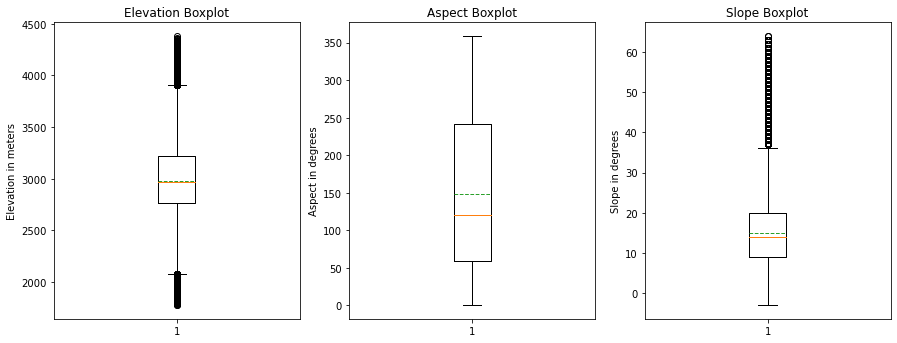

In [15]:
#boxplot visualization for more information on distributions
plt.figure(figsize=[15, 12])

plt.subplot(231)
plt.boxplot(x=train['Elevation'], showmeans=True, meanline=True)
plt.title('Elevation Boxplot')
plt.ylabel('Elevation in meters')

plt.subplot(232)
plt.boxplot(x=train['Aspect'], showmeans=True, meanline=True)
plt.title('Aspect Boxplot')
plt.ylabel('Aspect in degrees')

plt.subplot(233)
plt.boxplot(x=train['Slope'], showmeans=True, meanline=True)
plt.title('Slope Boxplot')
plt.ylabel('Slope in degrees')
plt.show()

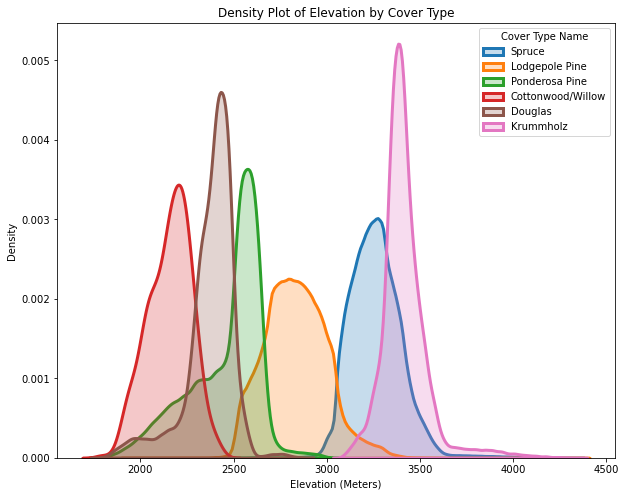

In [16]:
cover_type_mapping = {
    1: 'Spruce',
    2: 'Lodgepole Pine',
    3: 'Ponderosa Pine',
    4: 'Cottonwood/Willow',
    5: 'Aspen',
    6: 'Douglas',
    7: 'Krummholz'
}

plt.figure(figsize=[10, 8])

for name, group in train.groupby('Cover_Type'):
    sns.distplot(group['Elevation'], hist=False, kde=True, 
                 kde_kws={'shade': True, 'linewidth': 3},label=cover_type_mapping[name])
    
plt.legend(title='Cover Type Name')
plt.title('Density Plot of Elevation by Cover Type')
plt.xlabel('Elevation (Meters)')
plt.ylabel('Density')
plt.show()

We can see that the **Elevation** feature will be very useful in our machine learning models. This is because we can see a clear pattern and distinguishment between each different label and its corresponding elevation distribution. Each different label is well separated with minor overlap in their elevation.

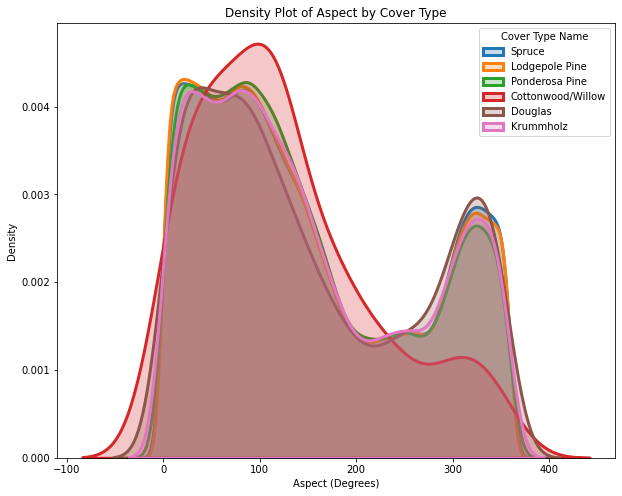

In [17]:
plt.figure(figsize=[10, 8])

for name, group in train.groupby('Cover_Type'):
    sns.distplot(group['Aspect'], hist=False, kde=True, 
                 kde_kws={'shade': True, 'linewidth': 3},label=cover_type_mapping[name])
    
plt.legend(title='Cover Type Name')
plt.title('Density Plot of Aspect by Cover Type')
plt.xlabel('Aspect (Degrees)')
plt.ylabel('Density')
plt.show()

It is a little harder to make a case for the usefulness of the **Aspect** feature column because as we can see the distributions across the different labels overlap each other. This feature column can still be useful because there is one label that stands out which Cottonwood/Willow. 

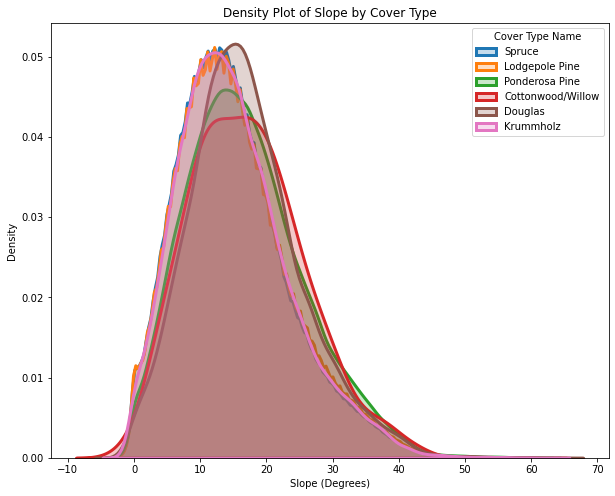

In [18]:
plt.figure(figsize=[10, 8])

for name, group in train.groupby('Cover_Type'):
    sns.distplot(group['Slope'], hist=False, kde=True, 
                 kde_kws={'shade': True, 'linewidth': 3},label=cover_type_mapping[name])
    
plt.legend(title='Cover Type Name')
plt.title('Density Plot of Slope by Cover Type')
plt.xlabel('Slope (Degrees)')
plt.ylabel('Density')
plt.show()

The **Slope** feature column may not be useful to us when making predictions. This is because as we can see all our labels overlap. There is no clear distinction of slope for certain labels.

In [19]:
#create dataframe for bar plot visualizations 
wilderness_df = train[wilderness_columns + ['Cover_Type']]

wilderness_df['Wilderness_Sum'] = train[wilderness_columns].sum(axis=1)

wilderness_df['Wilderness_Area0'] = wilderness_df['Wilderness_Sum'].apply(lambda x: 1 if x == 0 else 0)

cat_wilderness = pd.concat([wilderness_df.drop(['Cover_Type', 'Wilderness_Sum'], axis=1).idxmax(axis=1), 
           wilderness_df['Cover_Type']], axis=1)

cat_wilderness.columns = ['Wilderness_Area#', 'Cover_Type']

cat_wilderness['Wilderness_Area#'] = cat_wilderness['Wilderness_Area#'].apply(lambda x: int(x.replace('Wilderness_Area', '')))

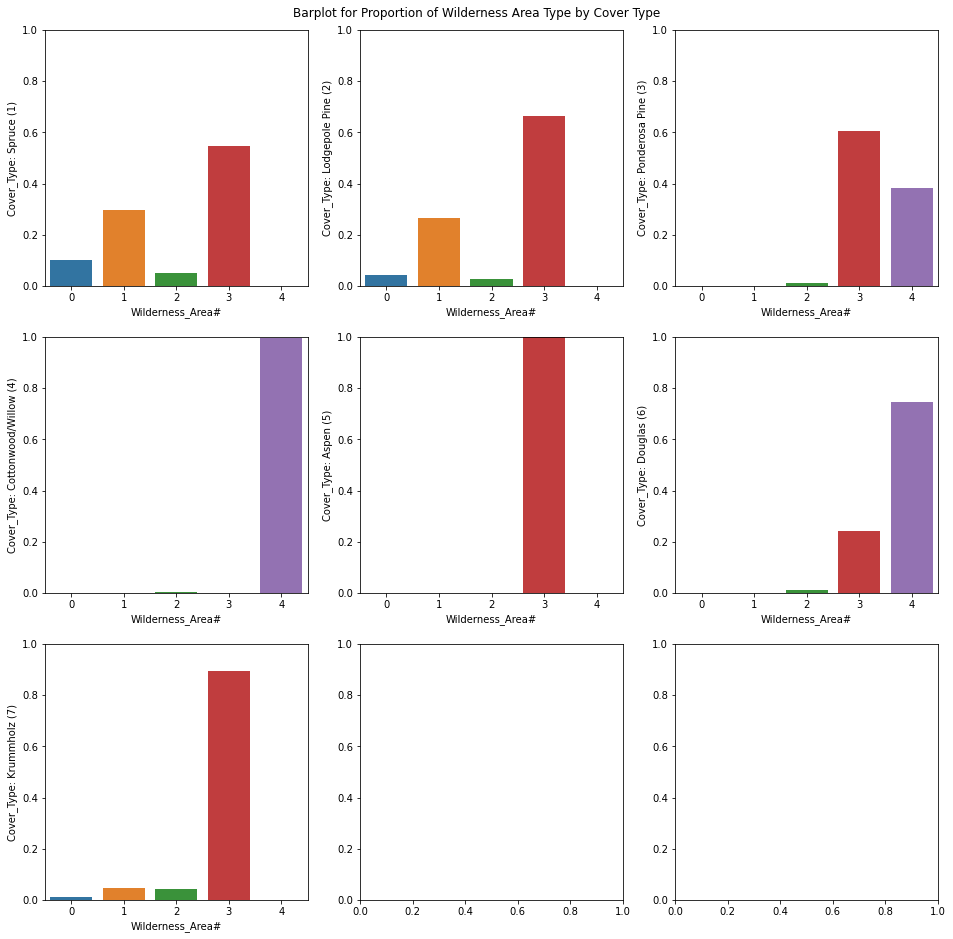

In [20]:
#barplot visualizations
fig, saxis = plt.subplots(3, 3, figsize=(16, 16))

x, y = 0, 0

for name, group in cat_wilderness.groupby('Cover_Type'):
    if y == 3:
        x += 1
        y = 0
    
    curr_df = (group.groupby('Wilderness_Area#').count() / group.shape[0]).reset_index()
    
    missing = list(set([0, 1, 2, 3, 4]).difference(curr_df['Wilderness_Area#'].tolist()))
    
    d = pd.DataFrame({
        'Wilderness_Area#': missing,
        'Cover_Type': np.zeros(len(missing))
    })
    
    curr_df = curr_df.append(d, ignore_index=True)
    
    #sort the df
    curr_df = curr_df.sort_values(by=['Wilderness_Area#'])
    
    curr_df['Wilderness_Area#'] = curr_df['Wilderness_Area#'].astype(int)
    
    g = sns.barplot(x='Wilderness_Area#', y='Cover_Type', data=curr_df, ax=saxis[x, y])

    g.axes.set_ylim(0, 1.0)
    
    g.set(ylabel='Cover_Type: ' + cover_type_mapping[name] + ' (' + str(name) + ')')
    y += 1
    
fig.suptitle('Barplot for Proportion of Wilderness Area Type by Cover Type' , y=0.90)
plt.show()

The **Wilderness_Area#** for most **Cover_Type** is Wilderness Area 3. The second most common Wilderness Area is 4. 

From the plots above it is easy to recognize that the Elevation feature is important in distinguishing between different Cover_Type. Therefore it would be important to compare elevation with other features.

In [21]:
wild_elev_df = pd.concat([cat_wilderness, train[['Elevation', 'Slope']]], axis=1)

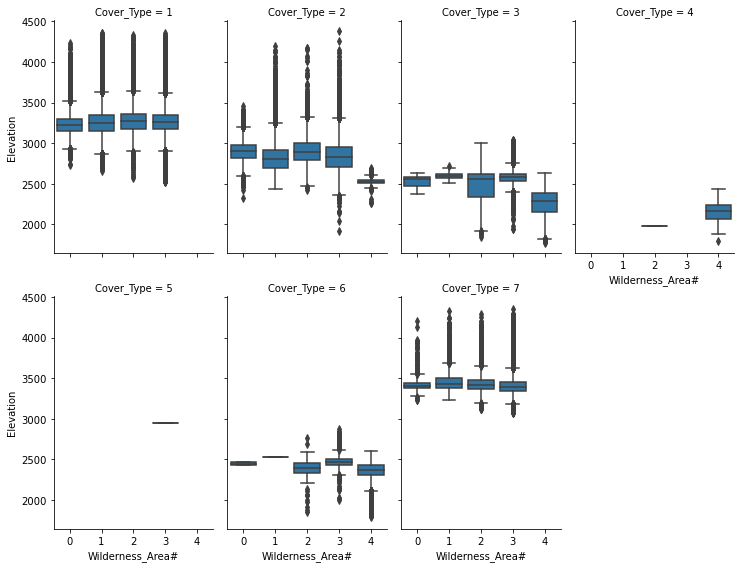

In [22]:
g = sns.FacetGrid(wild_elev_df, col="Cover_Type", col_wrap=4, height=4, aspect=.65)
g.map(sns.boxplot, "Wilderness_Area#", "Elevation", order=[0, 1, 2, 3, 4])

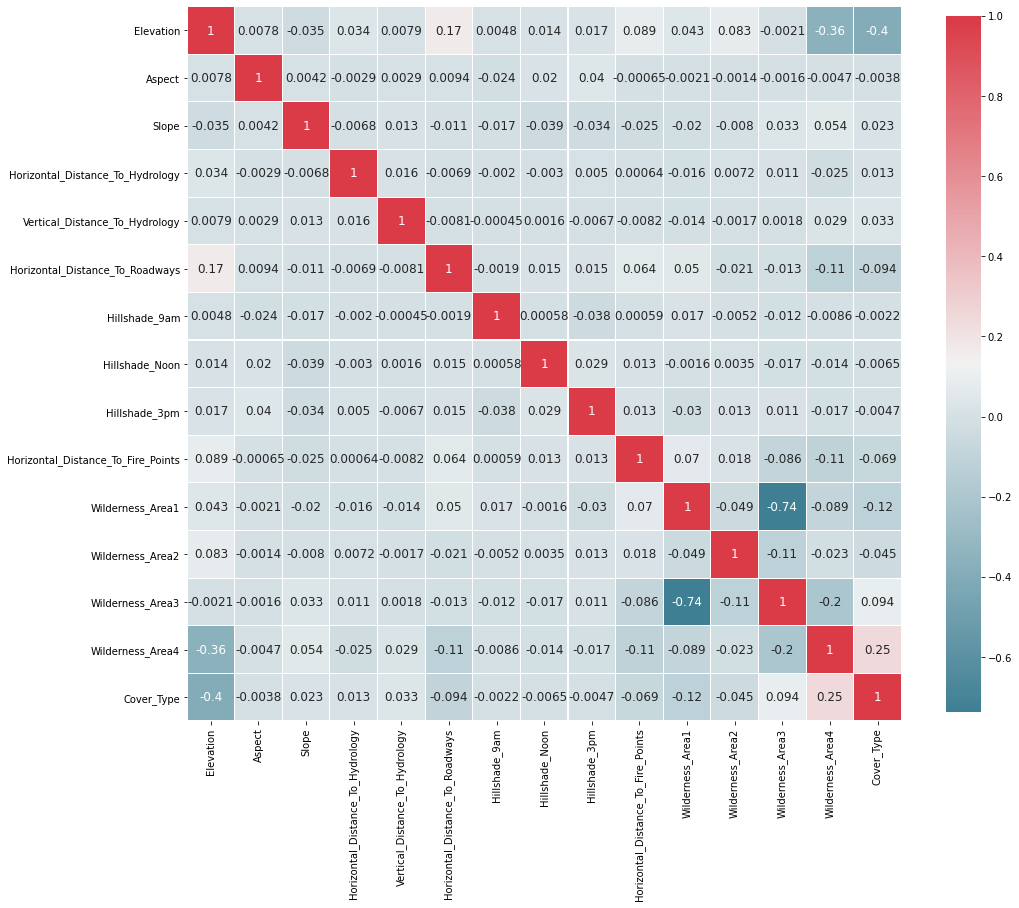

In [23]:
fig, ax = plt.subplots(figsize=(16, 16))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
fig = sns.heatmap(
    train.drop(soil_columns, axis=1).corr(),
    cmap = colormap,
    square=True,
    cbar_kws={'shrink': .8},
    ax=ax,
    annot=True,
    linewidths=0.1,
    vmax=1.0,
    linecolor='white',
    annot_kws={'fontsize': 12}
)

It is important to visualize the correlations amongst features. From above we can see that the **Wilderness_Area3** feature is highly correlated to the **Wilderness_Area1** feature. When building our model it is important to acknowledge this since we dont want features that are highly correlated with each other.

### Feature Engineering & Data Preparation

In [24]:
feature_train = train.copy(deep=True)

#create two features based if soil _type or wilderness_area are given
feature_train['Soil_Sum'] = feature_train[soil_columns].sum(axis=1)
feature_train['Has_Soil_Type'] = feature_train['Soil_Sum'].apply(lambda x: 1 if x >= 1 else 0)
feature_train['Has_Mult_Soil'] = feature_train['Soil_Sum'].apply(lambda x: 1 if x >= 2 else 0)
feature_train['Wilderness_Area_Sum'] = feature_train[wilderness_columns].sum(axis=1)
feature_train['Has_Wilderness_Area'] = feature_train['Wilderness_Area_Sum'].apply(lambda x: 1 if x >= 1 else 0)
feature_train['Double_Soil'] = feature_train['Soil_Sum'].apply(lambda x: 1 if x == 2 else 0)

#prepare the test set data with all the added features
test['Soil_Sum'] = test[soil_columns].sum(axis=1)
test['Has_Soil_Type'] = test['Soil_Sum'].apply(lambda x: 1 if x >= 1 else 0)
test['Has_Mult_Soil'] = test['Soil_Sum'].apply(lambda x: 1 if x >= 2 else 0)
test['Wilderness_Area_Sum'] = test[wilderness_columns].sum(axis=1)
test['Has_Wilderness_Area'] = test['Wilderness_Area_Sum'].apply(lambda x: 1 if x >= 1 else 0)
test['Double_Soil'] = test['Soil_Sum'].apply(lambda x: 1 if x == 2 else 0)

In [25]:
# Drop redundant columns
feature_train = feature_train.drop(soil_columns + ['Wilderness_Area3', 'Slope'], axis=1)
test = test.drop(soil_columns + ['Wilderness_Area3', 'Slope'], axis=1)

In [26]:
#reorganize columns so that target is at the end
reorganize = list(feature_train.columns)
reorganize.remove('Cover_Type')
reorganize.append('Cover_Type')

feature_train = feature_train[reorganize]

In [27]:
#save the features to csv file
# feature_train.to_csv('features.csv', index=False)

In [28]:
#dropping Cover_Type == 5 completely since there is only one row
cover_type_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    6: 4,
    7: 5,
    5: 999
}

feature_train['Cover_Type'] = feature_train['Cover_Type'].apply(lambda x: cover_type_map[x])
feature_train = feature_train[feature_train['Cover_Type'] != 999]

In [65]:
#get a small sample of the data to work on
sample = feature_train.sample(100000, random_state=0)

In [66]:
#split into features and target
X = sample.drop(['Cover_Type'], axis=1)
y = sample['Cover_Type']

In [67]:
#standardize our dataset
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [68]:
#split original train data into training, testing and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, random_state=0)

In [69]:
#we have a 60% train, 20% test split and 20% validation split
print('X_train Shape: {}'.format(X_train.shape))
print('X_test Shape: {}'.format(X_test.shape))
print('X_val Shape: {}'.format(X_val.shape))

X_train Shape: (60000, 18)
X_test Shape: (20000, 18)
X_val Shape: (20000, 18)


### Model Selection

Here the aim is to compare different machine learning models on a smaller sample of the original data (due to computational limits). Once we have caught a glimpse of the different performances of our models we can build upon the model which seems more promising. This will include hyperparamter tuning as well as training on the full dataset.

First model is a Linear Support Vector Classifier which achieves a 0.89951 training accuracy and a 0.89505 test set accuracy. 

In [35]:
from sklearn.svm import LinearSVC

In [38]:
start = time.time()
clf_svc = LinearSVC(random_state=0)

clf_svc.fit(X_train, y_train)

svc_y_train_pred = clf_svc.predict(X_train)
svc_y_test_pred = clf_svc.predict(X_test)

svc_y_train_acc = accuracy_score(y_train, svc_y_train_pred)
svc_y_test_acc = accuracy_score(y_test, svc_y_test_pred)

end = time.time()
print('SVC Process completed in', end-start, 'seconds')
print('SVC train accuracy:', svc_y_train_acc)
print('SVC test accuracy:', svc_y_test_acc)

SVC Process completed in 23.882088899612427 seconds
SVC train accuracy: 0.8995166666666666
SVC test accuracy: 0.89505


The second model that is going to be build is the Linear Discriminant Analysis classifier. This classifier achieves a training accuracy of 0.88551 and a test accuracy of 0.88145.

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [40]:
start = time.time()

clf_lda = LinearDiscriminantAnalysis()
clf_lda.fit(X_train, y_train)

lda_y_train_pred = clf_lda.predict(X_train)
lda_y_test_pred = clf_lda.predict(X_test)

lda_y_train_acc = accuracy_score(y_train, lda_y_train_pred)
lda_y_test_acc = accuracy_score(y_test, lda_y_test_pred)

end = time.time()
print('LDA Process completed in', end-start, 'seconds')
print('LDA train accuracy:', lda_y_train_acc)
print('LDA test accuracy:', lda_y_test_acc)

LDA Process completed in 0.17980599403381348 seconds
LDA train accuracy: 0.8855166666666666
LDA test accuracy: 0.88145


The third model is a SGDClassifier with L1 loss to bring some feature selection into the model. This model achieves a 0.89988 training accuracy and a 0.89655 test accuracy.

In [41]:
from sklearn.linear_model import SGDClassifier

In [42]:
start = time.time()

clf_sgd = SGDClassifier(penalty='l1', max_iter=1000, tol=1e-3, random_state=0)

clf_sgd.fit(X_train, y_train)

sgd_y_train_pred = clf_sgd.predict(X_train)
sgd_y_test_pred = clf_sgd.predict(X_test)

sgd_y_train_acc = accuracy_score(y_train, sgd_y_train_pred)
sgd_y_test_acc = accuracy_score(y_test, sgd_y_test_pred)

end = time.time()
print('SGD Process completed in', end-start, 'seconds')
print('SGD train accuracy:', sgd_y_train_acc)
print('SGD test accuracy:', sgd_y_test_acc)

SGD Process completed in 1.1179702281951904 seconds
SGD train accuracy: 0.8998833333333334
SGD test accuracy: 0.89655


The final model is going to be a basic tensorflow neural network. This model achieves a training accuracy of 0.94423 and a test set accuracy of 0.93704.

In [70]:
NUM_CLASSES = feature_train['Cover_Type'].nunique()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [71]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2658 - accuracy: 0.9057
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1903 - accuracy: 0.9294
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1784 - accuracy: 0.9325
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1713 - accuracy: 0.9342
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1667 - accuracy: 0.9361
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1618 - accuracy: 0.9381
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1593 - accuracy: 0.9389
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1566 - accuracy: 0.9400
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1529 - accuracy: 0.9407
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.151

In [72]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=1)

print('Test loss:', train_loss, '- Test accuracy:', train_acc)

1875/1875 [==============================] - 2s 822us/step - loss: 0.1442 - accuracy: 0.9442
Test loss: 0.14423483610153198 - Test accuracy: 0.9442333579063416


In [73]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', test_loss, '- Test accuracy:', test_acc)

625/625 [==============================] - 1s 844us/step - loss: 0.1665 - accuracy: 0.93700s - loss: 0.1650 - accuracy
Test loss: 0.16648082435131073 - Test accuracy: 0.9370499849319458


Now we can compare the models.

In [74]:
model_df = pd.DataFrame(data={
    'model_name': ['SVC', 'LDA', 'SGD', 'Tf NN'],
    'train_acc': [svc_y_train_acc, lda_y_train_acc, sgd_y_train_acc, train_acc],
    'test_acc': [svc_y_test_acc, lda_y_test_acc, sgd_y_test_acc, test_acc]
})

In [75]:
model_df.sort_values('test_acc', ascending=False)

,model_name,train_acc,test_acc
3,Tf NN,0.944233,0.93705
2,SGD,0.899883,0.89655
0,SVC,0.899517,0.89505
1,LDA,0.885517,0.88145


The SVC and SGD classifiers are very similar in terms of their accuracy performance but they vary greatly in terms of their run time. The SVC model takes 90 seconds to run while the SGD takes less than a second. Therefore I would prefer to build upon the SGD model since the runtime will allow me to test different parameters. Since the TensorFlow NN model achieved the highest training and test accuracy we can also build up on this model.

### Hyper-Parameter Tuning

Here we will input different loss, penalty and alpha parameters into the SGD classifier. This will allow us to see which model performs the best and with which parameters.

In [49]:
#list out different parameters to input for SGD model
loss_params = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
penalty_params = ['l2', 'l1', 'elasticnet']
alpha_params = [0.0001, 0.001, 0.01, 0.1]

In [51]:
start = time.time()

#keep track of the results for different parameters
data = {
    'loss': [],
    'penalty': [],
    'alpha': [],
    'train_accuracy': [],
    'test_accuracy': [],
    'runtime': []
}

#loop through different loss, penalty and alpha params and build model
for loss in loss_params:
    for penalty in penalty_params:
        for alpha in alpha_params:
            print('----- SGD model w/params:',loss,'loss',penalty,'penalty',alpha,'alpha -----')
            #build the model
            curr_sgd = SGDClassifier(loss=loss, 
                            penalty=penalty, 
                            alpha=alpha,
                            learning_rate='optimal',
                            max_iter=1000,
                            tol=1e-3,
                            random_state=0)
            train_start = time.time()
            #train the model here
            curr_sgd.fit(X_train, y_train)
            #get the training accuracy
            curr_train_acc = accuracy_score(y_train, curr_sgd.predict(X_train))
            #get the test accuracy
            curr_test_acc = accuracy_score(y_test, curr_sgd.predict(X_test))
            train_end = time.time()
            #save parameters for dataframe
            data['loss'].append(loss)
            data['penalty'].append(penalty)
            data['alpha'].append(alpha)
            data['train_accuracy'].append(curr_train_acc)
            data['test_accuracy'].append(curr_test_acc)
            data['runtime'].append(train_end-train_start) 
            print('Current SGD model train runtime:', train_end-train_start)

end = time.time()
print('Total Runtime:', end-start)

----- SGD model w/params: hinge loss l2 penalty 0.0001 alpha -----
Current SGD model train runtime: 0.7771909236907959
----- SGD model w/params: hinge loss l2 penalty 0.001 alpha -----
Current SGD model train runtime: 0.4302709102630615
----- SGD model w/params: hinge loss l2 penalty 0.01 alpha -----
Current SGD model train runtime: 0.35367298126220703
----- SGD model w/params: hinge loss l2 penalty 0.1 alpha -----
Current SGD model train runtime: 0.3028891086578369
----- SGD model w/params: hinge loss l1 penalty 0.0001 alpha -----
Current SGD model train runtime: 1.0367658138275146
----- SGD model w/params: hinge loss l1 penalty 0.001 alpha -----
Current SGD model train runtime: 0.568572998046875
----- SGD model w/params: hinge loss l1 penalty 0.01 alpha -----
Current SGD model train runtime: 0.45562124252319336
----- SGD model w/params: hinge loss l1 penalty 0.1 alpha -----
Current SGD model train runtime: 0.3933377265930176
----- SGD model w/params: hinge loss elasticnet penalty 0.0

In [52]:
#input results into dataframe
sgd_df = pd.DataFrame(data=data)

In [53]:
sgd_df.sort_values('train_accuracy', ascending=False).head()

,loss,penalty,alpha,train_accuracy,test_accuracy,runtime
5,hinge,l1,0.001,0.910233,0.9072,0.568573
30,modified_huber,l1,0.010,0.909067,0.9051,1.653699
29,modified_huber,l1,0.001,0.908867,0.9048,4.685415
17,log,l1,0.001,0.903317,0.8994,0.863625
10,hinge,elasticnet,0.010,0.903283,0.8992,0.495374


In [54]:
sgd_df.sort_values('test_accuracy', ascending=False).head()

,loss,penalty,alpha,train_accuracy,test_accuracy,runtime
5,hinge,l1,0.001,0.910233,0.9072,0.568573
30,modified_huber,l1,0.010,0.909067,0.9051,1.653699
29,modified_huber,l1,0.001,0.908867,0.9048,4.685415
17,log,l1,0.001,0.903317,0.8994,0.863625
10,hinge,elasticnet,0.010,0.903283,0.8992,0.495374


Now that we know the best parameters for our SGD model we can train it on the fill dataset rather than just a smaller sample. We will also build our tensorflow model to run more epochs.

In [78]:
#split into features and target
X = feature_train.drop(['Cover_Type'], axis=1)
y = feature_train['Cover_Type']

In [79]:
#standardize our dataset
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [80]:
#split original train data into training, testing and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, random_state=0)

In [81]:
#we have a 60% train, 20% test split and 20% validation split
print('X_train Shape: {}'.format(X_train.shape))
print('X_test Shape: {}'.format(X_test.shape))
print('X_val Shape: {}'.format(X_val.shape))

X_train Shape: (2399999, 18)
X_test Shape: (800000, 18)
X_val Shape: (800000, 18)


This is our optimal SGD model based on parameter tuning.

In [59]:
optimal_sgd = SGDClassifier(loss='hinge',
                 penalty='l1',
                 alpha=0.001,
                 learning_rate='optimal',
                 max_iter=1000,
                 tol=1e-3,
                 random_state=0)

start = time.time()
optimal_sgd.fit(X_train, y_train)
end = time.time()

print('Train accuracy:', accuracy_score(y_train, optimal_sgd.predict(X_train)))
print('Test accuracy:', accuracy_score(y_test, optimal_sgd.predict(X_test)))
print('Validation accuracy:', accuracy_score(y_val, optimal_sgd.predict(X_val)))
print('Runtime:', end-start)

Train accuracy: 0.9030212095921707
Test accuracy: 0.903515
Validation accuracy: 0.90293625
Runtime: 40.139012813568115


This is our TensorFlow Neural Network training on the full dataset for 5 epochs.

In [86]:
checkpoint_path = 'training_1/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

#create a callback that saves model weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [87]:
model.fit(X_train, y_train, epochs=5,
                validation_data=(X_test, y_test),
                callbacks=[cp_callback])

Epoch 1/5
74964/75000 [============================>.] - ETA: 0s - loss: 0.1566 - accuracy: 0.9387 ETA: 0s - loss: 0.1566 - 
Epoch 00001: saving model to training_1/cp.ckpt
75000/75000 [==============================] - 104s 1ms/step - loss: 0.1565 - accuracy: 0.9387 - val_loss: 0.1447 - val_accuracy: 0.9424
Epoch 2/5
74982/75000 [============================>.] - ETA: 0s - loss: 0.1415 - accuracy: 0.9433
Epoch 00002: saving model to training_1/cp.ckpt
75000/75000 [==============================] - 97s 1ms/step - loss: 0.1415 - accuracy: 0.9433 - val_loss: 0.1374 - val_accuracy: 0.9446
Epoch 3/5
74976/75000 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9443
Epoch 00003: saving model to training_1/cp.ckpt
75000/75000 [==============================] - 97s 1ms/step - loss: 0.1386 - accuracy: 0.9443 - val_loss: 0.1363 - val_accuracy: 0.9452
Epoch 4/5
74991/75000 [============================>.] - ETA: 0s - loss: 0.1372 - accuracy: 0.9448
Epoch 00004: saving model

In [88]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', test_loss, '- Test accuracy:', test_acc)

25000/25000 [==============================] - 20s 791us/step - loss: 0.1360 - accuracy: 0.9452s - loss: 0.1360 - accuracy: 0.
Test loss: 0.1360175758600235 - Test accuracy: 0.945243775844574


In [89]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)

print('Test loss:', val_loss, '- Test accuracy:', val_acc)

25000/25000 [==============================] - 23s 931us/step - loss: 0.1363 - accuracy: 0.9450s - los
Test loss: 0.13627801835536957 - Test accuracy: 0.9450200200080872


### Results

Upon building a test set prediction file (submission1.csv) from the optimal SGD model we achieved an accuracy of 0.89823 on the kaggle leaderboard. Using the TensorFlow NN model which build the test set prediction file (submission2.csv) we achieved an accuracy of 0.93424 on the kaggle leaderboard. This model is a vast improvement on the previous prediction. 

Both models show good signs since their result on the leaderboard is not far off from the results produced locally. This shows that models are converging and not overfitting. Moving forward with a little more feature engineering and model building it is entirely possible to improve the accuracy score.